# objective 

performance score after auction (high activity, high ending price vs starting price, large delta between value and winning bid)

In [189]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

# load data

In [190]:
# product, # of bids, bid increment, value, start $, end $
q = "select * from auctionitem"
df_ai = redshift_query_read(q, schema='production')

In [191]:
q = '''select
            ta.form,
            ta.product,
            ta.total as price,
            ta.status as status,
            count(distinct(b.ticketholder)) as bidders,
            count(b.ticketholder) as bids,
            count(distinct(ta.id)) as transactions,
            count(distinct(ta.bidder)) as winners
        from bidders as b
            left join transauction as ta on b.product=ta.product
        group by ta.product, ta.total, ta.status, ta.form'''
df_bids = redshift_query_read(q, schema='production')

In [192]:
df = df_ai.drop('id', axis=1).merge(df_bids, on='product')

In [193]:
df = df[(df['value']>0)&(df['bids']>1)]

# analysis

look at price over value and bid increments as ratio of value

In [194]:
df['price_ratio'] = df['price'] / df['value']
df['bidincrement_ratio'] = df['bidincrement'] / df['value']

In [195]:
outperformers = df[df['price']>df['value']]
underperformers = df[df['price']<=df['value']]

print("{:,} ({:.1f}%) outperformers".format(len(outperformers), (len(outperformers) / len(df)) * 100.))
print("{:,} ({:.1f}%) underperformers".format(len(underperformers), (len(underperformers) / len(df)) * 100.))

7,158 (20.2%) outperformers
28,230 (79.8%) underperformers


In [196]:
print("Outperformers")
print("\tMean price ratio: {:.2f}".format(outperformers['price_ratio'].mean()))
print("\tMedian price ratio: {:.2f}".format(outperformers['price_ratio'].median()))
print("\tMean bid increment ratio: {:.2f}".format(outperformers['bidincrement_ratio'].mean()))
print("\tMedian bid increment ratio: {:.2f}".format(outperformers['bidincrement_ratio'].median()))

print("Underperformers")
print("\tMean price ratio: {:.2f}".format(underperformers['price_ratio'].mean()))
print("\tMedian price ratio: {:.2f}".format(underperformers['price_ratio'].median()))
print("\tMean bid increment ratio: {:.2f}".format(underperformers['bidincrement_ratio'].mean()))
print("\tMedian bid increment ratio: {:.2f}".format(underperformers['bidincrement_ratio'].median()))

Outperformers
	Mean price ratio: 808.33
	Median price ratio: 1.30
	Mean bid increment ratio: 0.82
	Median bid increment ratio: 0.10
Underperformers
	Mean price ratio: 0.59
	Median price ratio: 0.58
	Mean bid increment ratio: 0.07
	Median bid increment ratio: 0.06


### price to value ratio

this is to be used as a metric of successful auction item

In [197]:
ratios = [(0.0, 0.25), (0.25, 0.50), (0.50, 0.75), (0.75, 1.0),
          (1.0, 1.25), (1.25, 1.50), (1.50, 2.0), (2.0, 5.0), 
          (5.0, 10.0), (10.0)]

In [198]:
# bucketing
print("All price/value ratio sample sizes")

for i in ratios:
    try:
        len_items = len(df[(df['price_ratio']>=i[0])&(df['price_ratio']<i[1])])
    except:
        len_items = len(df[df['price_ratio']>=i])
    print("{}: {:,} auction items; {:.1f}%".format(i, len_items, (len_items / len(df)) * 100.))

All price/value ratio sample sizes
(0.0, 0.25): 1,932 auction items; 5.5%
(0.25, 0.5): 7,729 auction items; 21.8%
(0.5, 0.75): 10,607 auction items; 30.0%
(0.75, 1.0): 6,388 auction items; 18.1%
(1.0, 1.25): 4,599 auction items; 13.0%
(1.25, 1.5): 1,559 auction items; 4.4%
(1.5, 2.0): 1,299 auction items; 3.7%
(2.0, 5.0): 966 auction items; 2.7%
(5.0, 10.0): 186 auction items; 0.5%
10.0: 123 auction items; 0.3%


In [199]:
print("Outperformers price/value ratio sample sizes")

for i in ratios:
    try:
        len_items = len(outperformers[(outperformers['price_ratio']>=i[0])&(outperformers['price_ratio']<i[1])])
    except:
        len_items = len(outperformers[outperformers['price_ratio']>=i])
    print("{}: {:,} auction items".format(i, len_items))

Outperformers price/value ratio sample sizes
(0.0, 0.25): 0 auction items
(0.25, 0.5): 0 auction items
(0.5, 0.75): 0 auction items
(0.75, 1.0): 0 auction items
(1.0, 1.25): 3,025 auction items
(1.25, 1.5): 1,559 auction items
(1.5, 2.0): 1,299 auction items
(2.0, 5.0): 966 auction items
(5.0, 10.0): 186 auction items
10.0: 123 auction items


In [200]:
print("Underperformers price/value ratio sample sizes")

for i in ratios:
    try:
        len_items = len(underperformers[(underperformers['price_ratio']>=i[0])&(underperformers['price_ratio']<i[1])])
    except:
        len_items = len(underperformers[underperformers['price_ratio']>=i])
    print("{}: {:,} auction items".format(i, len_items))

Underperformers price/value ratio sample sizes
(0.0, 0.25): 1,932 auction items
(0.25, 0.5): 7,729 auction items
(0.5, 0.75): 10,607 auction items
(0.75, 1.0): 6,388 auction items
(1.0, 1.25): 1,574 auction items
(1.25, 1.5): 0 auction items
(1.5, 2.0): 0 auction items
(2.0, 5.0): 0 auction items
(5.0, 10.0): 0 auction items
10.0: 0 auction items


### engagement - bid activity

In [201]:
print("All bids")
print("\tMedian: {:.2f}".format(df['bids'].median()))
print("\tMean: {:.2f}".format(df['bids'].mean()))
print("Outperformers bids")
print("\tMedian: {:.2f}".format(outperformers['bids'].median()))
print("\tMean: {:.2f}".format(outperformers['bids'].mean()))
print("Underperformers bids")
print("\tMedian: {:.2f}".format(underperformers['bids'].median()))
print("\tMean: {:.2f}".format(underperformers['bids'].mean()))

All bids
	Median: 10.00
	Mean: 47.24
Outperformers bids
	Median: 20.00
	Mean: 63.52
Underperformers bids
	Median: 8.00
	Mean: 43.11


In [202]:
bids_sets = [(0, 3), (3, 6), (6, 9), (9, 12), (12, 15),
            (15, 20), (20, 30), (30)]

In [203]:
print("Outperformers bids sample sizes")

for i in bids_sets:
    try:
        len_items = len(outperformers[(outperformers['bids']>=i[0])&(outperformers['bids']<i[1])])
    except:
        len_items = len(outperformers[outperformers['bids']>=i])
    print("{}: {:,} auction items; {:.1f}%".format(i, len_items, (len_items / len(outperformers)) * 100.))

Outperformers bids sample sizes
(0, 3): 513 auction items; 7.2%
(3, 6): 343 auction items; 4.8%
(6, 9): 477 auction items; 6.7%
(9, 12): 392 auction items; 5.5%
(12, 15): 762 auction items; 10.6%
(15, 20): 945 auction items; 13.2%
(20, 30): 1,675 auction items; 23.4%
30: 2,051 auction items; 28.7%


In [204]:
print("Underperformers bids sample sizes")

for i in bids_sets:
    try:
        len_items = len(underperformers[(underperformers['bids']>=i[0])&(underperformers['bids']<i[1])])
    except:
        len_items = len(underperformers[underperformers['bids']>=i])
    print("{}: {:,} auction items; {:.1f}%".format(i, len_items, (len_items / len(underperformers)) * 100.))

Underperformers bids sample sizes
(0, 3): 5,820 auction items; 20.6%
(3, 6): 4,025 auction items; 14.3%
(6, 9): 5,301 auction items; 18.8%
(9, 12): 2,213 auction items; 7.8%
(12, 15): 3,332 auction items; 11.8%
(15, 20): 2,208 auction items; 7.8%
(20, 30): 2,727 auction items; 9.7%
30: 2,604 auction items; 9.2%


In [230]:
ops = pd.cut(outperformers['bids'], bins=[r[0] for r in bids_sets[:-1]])
ups = pd.cut(underperformers['bids'], bins=[r[0] for r in bids_sets[:-1]])

In [231]:
ops = ops.reset_index()['bids'].value_counts().reset_index()
ups = ups.reset_index()['bids'].value_counts().reset_index()
ops.columns = ['sets', 'outperformers']
ups.columns = ['sets', 'underperformers']
bids_groups = ops.merge(ups, on='sets')

In [232]:
bids_groups['outperformers'] = bids_groups['outperformers'] / bids_groups['outperformers'].sum()
bids_groups['underperformers'] = bids_groups['underperformers'] / bids_groups['underperformers'].sum()

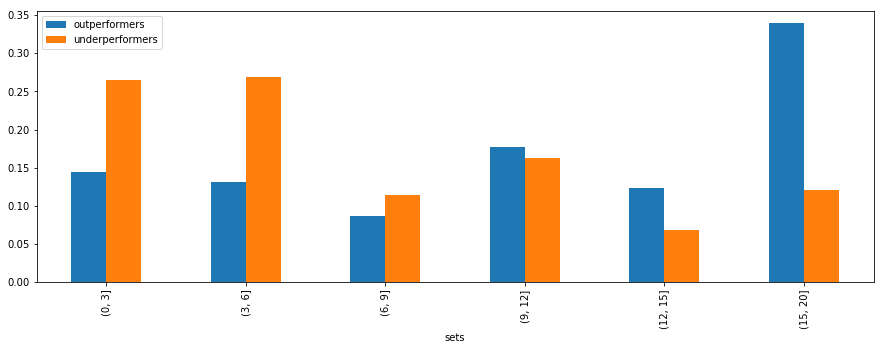

In [233]:
bids_groups.sort_values('sets').plot(x='sets', figsize=(15,5), kind='bar')

outperformers clearly have a tendency toward greater engagement, peaking in the 6 to 9 group. underperformers however peak in the 3 to 6 group with the 0 to 3 group extremely close behind. causation cannot be immediately discerned here, however, as we would naturally expect greater engagement to result in greater bid values and push an item into the outperformer category.

engagement could be a good metric for determining performance but we need to determine qualities of the item that prove influential in engagement.

## performance consistency

looking at average overperformer/underperformer ranks per form. is a form generally one or the other for all auction items or is it random?

In [234]:
df['outperformer'] = df['price'] > df['value']
df['underperformer'] = df['price'] <= df['value']

In [235]:
form_perf_consistency = df.groupby(['form'])[['outperformer', 'underperformer']].mean().reset_index()

In [236]:
form_perf_consistency[['outperformer', 'underperformer']].agg(['mean', 'median'])

,outperformer,underperformer
mean,0.175598,0.824402
median,0.122514,0.877486


In [237]:
print("Forms w/ > 50% outperforming items")
form_perf_consistency[form_perf_consistency['outperformer']>.5][['outperformer', 'underperformer']].agg(['mean', 'median'])

Forms w/ > 50% outperforming items


,outperformer,underperformer
mean,0.740824,0.259176
median,0.666667,0.333333


In [238]:
print("Forms w/ > 50% underperforming items")
form_perf_consistency[form_perf_consistency['underperformer']>.5][['outperformer', 'underperformer']].agg(['mean', 'median'])

Forms w/ > 50% underperforming items


,outperformer,underperformer
mean,0.132982,0.867018
median,0.111111,0.888889


Item performance does appear to be rather consistent with underperforming items, but the outperforming items appears more random

## reserve

In [239]:
len_res = len(df[df['reserve']>0])
perc_res = (len_res / len(df)) * 100.
print("{:,} ({:.2f}%) items w/ a reserve".format(len_res, perc_res))

4,957 (14.01%) items w/ a reserve


In [240]:
df['has_reserve'] = df['reserve']>0

In [241]:
df.groupby('has_reserve')[['outperformer', 'underperformer']].agg(['mean', 'median']).reset_index()

has_reserve outperformer        underperformer       
                      mean median           mean median
0       False     0.192567    0.0       0.807433    1.0
1        True     0.261852    0.0       0.738148    1.0

__the incidence of outperformers is greater among itmes with a reserve__

In [242]:
df['reserve_ratio'] = df['reserve'] / df['value']
df[df['has_reserve']]['reserve_ratio'].agg(['median', 'mean'])

median    0.500000
mean      7.605558
Name: reserve_ratio, dtype: float64

In [243]:
# look at average OP/UP & price/value among reserve segments
res_ranges = [(0., 0.25), (0.25, 0.5), 
              (0.5, 0.75), (0.75, 1.0)]

for r in res_ranges:
    _df = df[(df['reserve_ratio']>r[0])&(df['reserve_ratio']<=r[1])]
    print("reserve/value ratio {}:".format(r))
    print("\tsample size: {:,}".format(len(_df)))
    print("\top: mean {:.2f}; median {:.2f}".format(_df['outperformer'].mean(), _df['outperformer'].median()))
    print("\tup: mean {:.2f}; median {:.2f}".format(_df['underperformer'].mean(), _df['underperformer'].median()))
    print("\tprice_ratio: mean {:.2f}; median {:.2f}".format(_df['price_ratio'].mean(), _df['price_ratio'].median()))

reserve/value ratio (0.0, 0.25):
	sample size: 520
	op: mean 0.23; median 0.00
	up: mean 0.78; median 1.00
	price_ratio: mean 0.90; median 0.44
reserve/value ratio (0.25, 0.5):
	sample size: 2,385
	op: mean 0.16; median 0.00
	up: mean 0.84; median 1.00
	price_ratio: mean 0.71; median 0.62
reserve/value ratio (0.5, 0.75):
	sample size: 1,220
	op: mean 0.34; median 0.00
	up: mean 0.66; median 1.00
	price_ratio: mean 0.91; median 0.80
reserve/value ratio (0.75, 1.0):
	sample size: 680
	op: mean 0.38; median 0.00
	up: mean 0.62; median 1.00
	price_ratio: mean 1.07; median 0.98


The reserve ratio performance appears to track closely with with the reserve itself. Ie, the median item performance in each reserve ratio segment is very close to a slight gain above the average reserve ratio for the given segment. This is an unsurprising result and does not lead to a conclusion of an ideal reserve ratio.

In [244]:
# compare to price/value ratio for similarly valued item w/out reserves
val_ranges = [(0, 25), (25, 50), (50, 100), 
              (100, 150), (150, 250), (250, 500), 500]
mean_diffs = []
median_diffs = []

for v in val_ranges:
    try:
        _df = df[(df['value']>v[0])&(df['value']<=v[1])]
    except:
        _df = df[df['value']>v]
        
    mean_w_reserve = _df[_df['has_reserve']]['price_ratio'].mean()
    median_w_reserve = _df[_df['has_reserve']]['price_ratio'].median()
    mean_wout_reserve = _df[~_df['has_reserve']]['price_ratio'].mean()
    median_wout_reserve = _df[~_df['has_reserve']]['price_ratio'].median()
    
    this_mean_diff = ((mean_w_reserve - mean_wout_reserve) / mean_wout_reserve) * 100.
    mean_diffs.append(this_mean_diff)
    this_median_diff = ((median_w_reserve - median_wout_reserve) / median_wout_reserve) * 100.
    median_diffs.append(this_median_diff)
    
    print("value {}: {:,} items".format(v, len(_df)))
    print("\tp/v: mean {:.2f}; median {:.2f}".format(_df['price_ratio'].mean(), _df['price_ratio'].median()))
    print("\tp/v w/ reserve: mean {:.2f}; median {:.2f}".format(mean_w_reserve, median_w_reserve))
    print("\tp/v w/out reserve: mean {:.2f}; median {:.2f}".format(mean_wout_reserve, median_wout_reserve))
    print("\tmean diff w/ reserve: mean {:,.2f}%; median {:,.2f}%".format(this_mean_diff, this_median_diff))
    
print()
print("Mean diff means: {:,.2f}%".format(np.mean(mean_diffs)))
print("Mean diff medians: {:,.2f}%".format(np.mean(median_diffs)))

value (0, 25): 2,025 items
	p/v: mean 2850.24; median 1.00
	p/v w/ reserve: mean 176.26; median 0.98
	p/v w/out reserve: mean 3459.96; median 1.00
	mean diff w/ reserve: mean -94.91%; median -2.17%
value (25, 50): 4,777 items
	p/v: mean 1.17; median 0.86
	p/v w/ reserve: mean 0.97; median 0.89
	p/v w/out reserve: mean 1.20; median 0.86
	mean diff w/ reserve: mean -19.05%; median 3.70%
value (50, 100): 8,156 items
	p/v: mean 0.85; median 0.75
	p/v w/ reserve: mean 0.93; median 0.75
	p/v w/out reserve: mean 0.84; median 0.75
	mean diff w/ reserve: mean 10.07%; median 0.00%
value (100, 150): 4,834 items
	p/v: mean 0.73; median 0.67
	p/v w/ reserve: mean 0.78; median 0.67
	p/v w/out reserve: mean 0.72; median 0.66
	mean diff w/ reserve: mean 7.96%; median 0.68%
value (150, 250): 5,725 items
	p/v: mean 0.71; median 0.60
	p/v w/ reserve: mean 0.76; median 0.65
	p/v w/out reserve: mean 0.71; median 0.60
	mean diff w/ reserve: mean 7.39%; median 8.33%
value (250, 500): 5,613 items
	p/v: mean 0

There is a consistent advantage to implementing a reserve with an auction item. There are outliers dragging the mean's into unreasonable values but examining the median's shows a clear advantage with an average gain of 12% throughout all values segments for items with a reserve value with more pronounced effects with high value items (250+).

In [245]:
ratios = [(0.0, 0.025), (0.025, 0.05), (0.05, 0.075), 
          (0.075, 0.10), (0.10, 0.15), (0.15, 0.20), 
          (0.20, 0.50), (0.50, 0.75), (0.75)]

In [246]:
# bucketing
print("All bid increment ratio sample sizes")

for i in ratios:
    try:
        len_items = len(df[(df['bidincrement_ratio']>=i[0])&(df['bidincrement_ratio']<i[1])])
        mdn = df[(df['bidincrement_ratio']>=i[0])&(df['bidincrement_ratio']<i[1])]['price_ratio'].median()
    except:
        len_items = len(df[df['bidincrement_ratio']>=i])
        mdn = df[df['bidincrement_ratio']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

All bid increment ratio sample sizes
(0.0, 0.025): 4,609 auction items; median price/value: 0.51
(0.025, 0.05): 6,892 auction items; median price/value: 0.55
(0.05, 0.075): 8,508 auction items; median price/value: 0.64
(0.075, 0.1): 4,172 auction items; median price/value: 0.72
(0.1, 0.15): 8,201 auction items; median price/value: 0.80
(0.15, 0.2): 1,114 auction items; median price/value: 0.83
(0.2, 0.5): 1,537 auction items; median price/value: 1.00
(0.5, 0.75): 29 auction items; median price/value: 2.00
0.75: 326 auction items; median price/value: 5.00


In [247]:
print("Outperformers bid increment ratio sample sizes")

for i in ratios:
    try:
        len_items = len(outperformers[(outperformers['bidincrement_ratio']>=i[0])&(outperformers['bidincrement_ratio']<i[1])])
        mdn = outperformers[(outperformers['bidincrement_ratio']>=i[0])&(outperformers['bidincrement_ratio']<i[1])]['price_ratio'].median()
    except:
        len_items = len(outperformers[outperformers['bidincrement_ratio']>=i])
        mdn = outperformers[outperformers['bidincrement_ratio']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

Outperformers bid increment ratio sample sizes
(0.0, 0.025): 555 auction items; median price/value: 1.32
(0.025, 0.05): 653 auction items; median price/value: 1.24
(0.05, 0.075): 1,377 auction items; median price/value: 1.21
(0.075, 0.1): 930 auction items; median price/value: 1.23
(0.1, 0.15): 2,322 auction items; median price/value: 1.30
(0.15, 0.2): 354 auction items; median price/value: 1.33
(0.2, 0.5): 632 auction items; median price/value: 1.40
(0.5, 0.75): 15 auction items; median price/value: 3.00
0.75: 320 auction items; median price/value: 5.00


In [248]:
print("Underperformers bid increment ratio sample sizes")

for i in ratios:
    try:
        len_items = len(underperformers[(underperformers['bidincrement_ratio']>=i[0])&(underperformers['bidincrement_ratio']<i[1])])
        mdn = underperformers[(underperformers['bidincrement_ratio']>=i[0])&(underperformers['bidincrement_ratio']<i[1])]['price_ratio'].median()
    except:
        len_items = len(underperformers[underperformers['bidincrement_ratio']>=i])
        mdn = underperformers[underperformers['bidincrement_ratio']>=i]['price_ratio'].median()
        
    print("{}: {:,} auction items; median price/value: {:.2f}".format(i, len_items, mdn))

Underperformers bid increment ratio sample sizes
(0.0, 0.025): 4,054 auction items; median price/value: 0.47
(0.025, 0.05): 6,239 auction items; median price/value: 0.52
(0.05, 0.075): 7,131 auction items; median price/value: 0.57
(0.075, 0.1): 3,242 auction items; median price/value: 0.62
(0.1, 0.15): 5,879 auction items; median price/value: 0.66
(0.15, 0.2): 760 auction items; median price/value: 0.67
(0.2, 0.5): 905 auction items; median price/value: 0.75
(0.5, 0.75): 14 auction items; median price/value: 1.00
0.75: 6 auction items; median price/value: 0.00


In [249]:
ops = pd.cut(outperformers['bidincrement_ratio'], bins=[r[0] for r in ratios[:-1]])
ups = pd.cut(underperformers['bidincrement_ratio'], bins=[r[0] for r in ratios[:-1]])
buckets = pd.DataFrame([ops, ups], columns=['outperformers', 'underperformers'])

In [250]:
ops = ops.reset_index()['bidincrement_ratio'].value_counts().reset_index()
ups = ups.reset_index()['bidincrement_ratio'].value_counts().reset_index()
ops.columns = ['ratio', 'outperformers']
ups.columns = ['ratio', 'underperformers']
bi_ratios = ops.merge(ups, on='ratio')

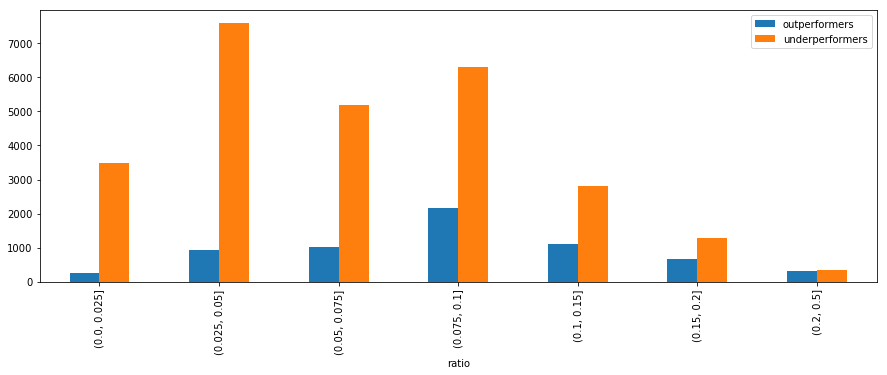

In [251]:
bi_ratios.sort_values('ratio').plot(x='ratio', figsize=(15,5), kind='bar')

charting raw counts. earlier peaks in the underperformers is clearly indicating that underperformers tend to use smaller bid increments relative the item value.

in order to more easily see the difference, we will normalize the sample sizes to see them in equal dimension.

In [252]:
bi_ratios['outperformers'] = bi_ratios['outperformers'] / bi_ratios['outperformers'].sum()
bi_ratios['underperformers'] = bi_ratios['underperformers'] / bi_ratios['underperformers'].sum()

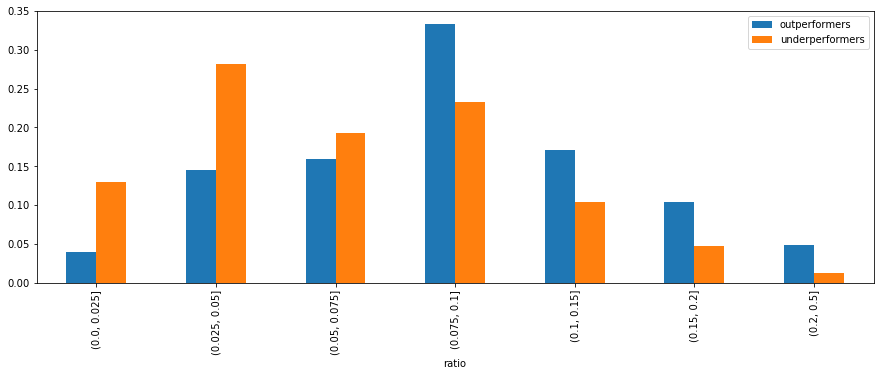

In [253]:
bi_ratios.sort_values('ratio').plot(x='ratio', figsize=(15,5), kind='bar')

normalized, it is clear to see that underperforming auction items have a tendency toward bid increments of 2.5% to 5% of the item value whereas the outperforming auction items have a tendency toward bid increments of 7.5% to 10% of the item value

__this is a good stat for a recommendation__

looking at all auction items, the median price/value ratio increases with an increase in the bid increment/value consistently

In [254]:
# examining specific bidincrement/value ratios
bidincrement_ratios = [(0.0, 0.025), (0.025, 0.05), (0.05, 0.075), 
          (0.075, 0.10), (0.10, 0.15), (0.15, 0.20), 
          (0.20, 0.50), (0.50, 0.75), (0.75)]
price_ratios = [0.0, 0.25, 0.50, 0.75, 1.0,
              1.25, 1.50, 2.0, 5.0, 10.0]

for i in bidincrement_ratios:
    print(i)
    
    try:
        items = df[(df['bidincrement_ratio']>=i[0])&(df['bidincrement_ratio']<i[1])]
    except:
        items = df[df['bidincrement_ratio']>=i]
        
    print(pd.cut(items['price_ratio'], bins=price_ratios).value_counts().reset_index().sort_values('index'))
        
    print()

(0.0, 0.025)
         index  price_ratio
2  (0.0, 0.25]          779
0  (0.25, 0.5]         1453
1  (0.5, 0.75]         1127
3  (0.75, 1.0]          655
4  (1.0, 1.25]          248
5  (1.25, 1.5]           95
6   (1.5, 2.0]           94
7   (2.0, 5.0]           79
8  (5.0, 10.0]            7

(0.025, 0.05)
         index  price_ratio
3  (0.0, 0.25]          619
0  (0.25, 0.5]         2387
1  (0.5, 0.75]         1966
2  (0.75, 1.0]         1229
4  (1.0, 1.25]          364
5  (1.25, 1.5]          152
6   (1.5, 2.0]           82
7   (2.0, 5.0]           51
8  (5.0, 10.0]            4

(0.05, 0.075)
         index  price_ratio
4  (0.0, 0.25]          394
1  (0.25, 0.5]         2352
0  (0.5, 0.75]         2587
2  (0.75, 1.0]         1772
3  (1.0, 1.25]          748
5  (1.25, 1.5]          310
6   (1.5, 2.0]          192
7   (2.0, 5.0]          121
8  (5.0, 10.0]            6

(0.075, 0.1)
         index  price_ratio
6  (0.0, 0.25]           90
1  (0.25, 0.5]          978
0  (0.5, 0.75]     

there is a consistent intersection of peaking price/value ratio samples around 0.75 to 1.25 bid increment/value ratios. we still see a strong positive correlation between the two metrics but pushing greater bid increment/value ratios could have unforeseen negative effects if recommended universally. _a safe course of action would be to recommend a 10% bid increment/value ratio while never recommending to decrease the bid increment in cases that users feel greater values are desirable. over time, as this recommendation is applied, we will see a new floor develop at 10% and we can reassess with larger sample sizes._

# score

after auction item score. considerations:
- bids count
- winning bid/value
- bid increment/value
- reserve/value 

In [265]:
len_all = len(df)
len_1bidder = len(df[df['bidders']==1])
perc_1bidder = (len_1bidder / len_all) * 100.

print("{:,} ({:.2f}%) auction items have only 1 bidder".format(len_1bidder, perc_1bidder))
print("bids: {:.2f} mean, {:.2f} median".format(df['bids'].mean(), df['bids'].median()))

34,488 (97.46%) auction items have only 1 bidder
bids: 47.24 mean, 10.00 median


In [262]:
cols = ['price_ratio', 'bids', 'bidincrement', 
        'bidincrement_ratio', 'reserve_ratio']
df[cols].tail(3)

,price_ratio,bids,bidincrement,bidincrement_ratio,reserve_ratio
47799,0.517241,2,15.0,0.103448,0.517241
47802,0.628571,42,10.0,0.028571,0.000000
47803,0.628571,42,10.0,0.028571,0.000000


In [266]:
# bid increment >= 10% value
df['bidincrement_score'] = df['bidincrement_ratio']>=0.10
# reserve >= 25% value
df['reserve_score'] = df['reserve_ratio']>=0.25
# bids > median
df['bids_score'] = df['bids'] >= df['bids'].median()
# price/value >= 1.0
df['winningbid_score'] = df['price_ratio'] >= 1.0

score_cols = ['bidincrement_score', 'reserve_score', 
              'bids_score', 'winningbid_score']
df['score'] = df[score_cols].mean(axis=1)

In [267]:
cols = ['score', 'price_ratio', 'bids', 'bidincrement', 
        'bidincrement_ratio', 'reserve_ratio']
df[cols].tail(5)

,score,price_ratio,bids,bidincrement,bidincrement_ratio,reserve_ratio
47797,0.50,1.422222,64,20.0,0.044444,0.000000
47798,0.50,0.517241,2,15.0,0.103448,0.517241
47799,0.50,0.517241,2,15.0,0.103448,0.517241
47802,0.25,0.628571,42,10.0,0.028571,0.000000
47803,0.25,0.628571,42,10.0,0.028571,0.000000


In [268]:
df['score'].value_counts()

0.25    15180
0.00     8521
0.50     7481
0.75     3767
1.00      439
Name: score, dtype: int64